In [1]:
__author__ = 'lisette.espin'

%matplotlib inline
#%config InlineBackend

################################################################################
### Dependencies
################################################################################
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import networkx as nx
from scipy.sparse import csr_matrix
from collections import defaultdict
import numpy as np
import copy
import warnings
from scipy.special import gammaln, gamma
from random import randint, uniform, randrange
from scipy.sparse import coo_matrix
import operator
import sys
import copy

################################################################################
### CONSTANTS
################################################################################
NODES = 50                                 # number of nodes
EDGES = NODES - 1                          # number of edges (barabassi)
RADIUS = 1.0                               # radius for geometric graph
DIRECTED = True                            # True if directed graph, False otherwise
WEIGHTED = True                            # True if weighted graph, False otherwise
GLOBAL = False                             # True if global matrix-based norm, local row-based otherwise
NORM = True                                # True if matrix of beliefs needs to be normalized
MODE = 'integers'                          # integers or reals pseudo counts
K = 10                                     # maximun weighting factor k
WEIGHTING_FACTORS = np.logspace(-1,K,K+2)  # range of k values
Kprint = 100000                            # k value to print (ranked hypotheses)
P = 0.5                                    # probability of edge formation   
MINW = 1.                                  # min value of edge weights
MAXW = 100.                                # max value of edge weights
ALGO = 'erdos-renyi'                       # erdos-renyi, geometric, barabassi, uniform
UNIFORM = 1/float(NODES-1)                 # prob for uniform

In [2]:
################################################################################
### main Class: JANUS
################################################################################
class JANUS(object):
    def __init__(self,algorithm,isdirected,isweighted,isglobal,norm,mode,**kwargs):
        self.algorithm = algorithm
        self.isdirected = isdirected
        self.isweighted = isweighted
        self.isglobal = isglobal
        self.norm = norm
        self.mode = mode
        self.n = None if 'n' not in kwargs else kwargs['n']
        self.p = None if 'p' not in kwargs else kwargs['p']
        self.m = None if 'm' not in kwargs else kwargs['m']
        self.r = None if 'r' not in kwargs else kwargs['r']
        self.minw = None if 'minw' not in kwargs else kwargs['minw']
        self.maxw = None if 'maxw' not in kwargs else kwargs['maxw']
        self.noise = None if 'noise' not in kwargs else kwargs['noise']
        self.G = None
        self.D = None
        self.M = None
        
    ############################################################################
    ### Graph generators
    ############################################################################
    
    def createGraph(self):
        if self.isweighted:
            self.createRandomWeightedGraph()
            self.D = nx.adjacency_matrix(self.G)
        else:
            self.createRandomUnweightedGraph()
            self.D = nx.adjacency_matrix(self.G,weight='weight')
            
        self.M = csr_matrix(self.D, dtype=np.float64)
        self.updateAdjacencyMatrix()
        
    def updateAdjacencyMatrix(self):
        self._checkIfNoise()
        self.M.setdiag(self.M.diagonal()*0.)
        
        
    def _checkIfNoise(self):
        if self.noise is not None:
            cx = coo_matrix(self.D, dtype=np.float64)
            for i,j,v in zip(cx.row, cx.col, cx.data):
                if self.isweighted:
                    noise = uniform(self.noise*-1,self.noise)
                    noise = int(noise)
                    self.M[i,j] = v + noise
                else:
                    noise = uniform(0,self.noise)
                    noise = int(noise)
                    self.M[i,j] = v + (noise if v == 0 else noise*-1) ### is this correct?
            
            self.M[self.M < 0.] = 0.
            if not self.isweighted:
                self.M[self.M > 1.] = 1.
                
    def _graph_generator(self):
        '''
        Calls the respective graph generator functions according to algorithm
        '''
        if self.algorithm == 'erdos-renyi':
            self.G = nx.erdos_renyi_graph(n=self.n, p=self.p, directed=self.isdirected)
        elif self.algorithm == 'barabassi':
            self.G = nx.barabasi_albert_graph(n=self.n, m=self.m)
        elif self.algorithm == 'geometric':
            self.G = nx.random_geometric_graph(n=self.n, radius=self.r)
        elif self.algorithm == 'uniform':
            self.G = nx.complete_graph(n=self.n)
        else:
            print 'ERROR {} algorithm does NOT exist.'.format(self.algorithm)

    def createRandomUnweightedGraph(self):
        '''
        Creates a random graph. Linkages are made according to algorithm (erdos,barabassi,etc.)
        '''
        self._graph_generator()
        
    def createRandomWeightedGraph(self):
        '''
        Creates a random graph. Linkages are made according to algorithm (erdos,barabassi,etc.)
        Weights are inferred at random from minw to maxw, both inclusive.
        '''
        self.createRandomUnweightedGraph()
        
        for u,v,d in self.G.edges(data=True):
            w = self.p if self.algorithm == 'uniform' else randint(self.minw,self.maxw)
            self.G[u][v]['weight'] = w

    def copyWithNoise(self, noise):
        '''
        Given a matrix D (adjacency matrix of a graph G) it adds random noise into its cells.
        The noise is a random number from 0 to noise if the matrix is unweighted.
        For weighted graphs the noise goes from -noise to noise.
        returns csr_matrix
        '''
        #H = copy.deepcopy(self)
        H = JANUS(algorithm = self.algorithm, isdirected = self.isdirected, isweighted = self.isweighted, isglobal = self.isglobal, norm = self.norm, mode = self.mode, n = self.n, p = self.p, m = self.m, r = self.r, minw = self.minw, maxw = self.maxw, noise=noise)
        H.G = self.G.copy()
        H.D = self.D.copy()
        H.M = self.M.copy()
        H.updateAdjacencyMatrix()
        return H
            
    ############################################################################
    ### Priors (Beliefs)
    ############################################################################
    
    def elicit_prior(self, k):
        if k == 0.1:
            return csr_matrix(self.D.shape, dtype=np.float64)
        elif self.isglobal:
            return self.elicit_prior_global(k)
        return self.elicit_prior_local(k)
            
            
    def elicit_prior_global(self, k):
        '''
        Eliciting prior (beliefs)
        Normalizing Globally (matrix-based)
        '''
        if self.norm:
            matrix_sum = self.M.sum()
            prior = self.M / matrix_sum

        if self.mode == "integers":
            prior = prior * k

        return prior
    
    def elicit_prior_local(self, k):
        '''
        Eliciting prior (beliefs)
        Normalizing Locally (row-based)
        '''
        if self.norm:
            matrix_sum_rows = self.M.sum(axis=1)
            prior = csr_matrix(self.M.toarray() / matrix_sum_rows)

        if self.mode == "integers":
            prior = prior * k

        return prior
    

In [3]:
################################################################################
### Model Class: Likelihood
################################################################################

class CategoricalDistribution(object):
    
    def __init__(self, use_prior=False, prior=1., specific_prior_vocab = None, modus='bayes', isdirected=False):
        '''
        Constructor
        :param use_prior: flag if script should use a prior
        :param prior: prior (pseudo count) for each single element (in case of MLE it is smoothing)
        Note that usually the values should directly represent the additional alpha values for corresponding elements.
        :param specific_prior_vocab: dictionary of vocabulary that matches state names with indices
        of the specific_prior matrix
        :param modus: specifies the modus of the class, there are two possibilities: modus='mle' is focused on working
        with mle matrices representing probabilities
        :param  modus: 'bayes' focuses on working with bayesian evidence and only works with plain transition counts
        '''

        self.nodes_count_ = len(specific_prior_vocab)
        self.parameter_count_ = 0
        self.observation_count_ = 0

        #probabilities
        self.edges_dict_ = defaultdict(lambda : defaultdict(float))
        self.edges_dict_norm_ = None

        self.prediction_position_dict_ = dict()
        self.dtype_ = np.dtype(float)
        self.modus_ = modus
        self.isdirected = isdirected

        self.use_prior_ = use_prior
        self.alpha_ = prior
        
        self.specific_prior_vocab_ = specific_prior_vocab

        self.proba_from_unknown_ = 0
        self.proba_to_unknown_ = dict()

    def prepare_data(self, G):
        '''
        Function for preparing the data
        ALWAYS CALL FIRST
        :param G: graphs (networkx) including all nodes and edges
        '''

        # unique nodes
        nodes = nx.nodes(G)

        self.nodes_initial_ = frozenset(nodes)

        if self.nodes_count_ < float(len(nodes)):
            raise Exception("You set the nodes_count too low!")

        # number of unique nodes
        if self.nodes_count_ is None:
            self.nodes_count_ = float(len(nodes))

    def fit(self, G):
        '''
        Fitting the data and constructing MLE
        :param G: graphs (networkx) including all nodes and edges
        '''

        nodes = nx.nodes(G)
        for n1 in nodes:
            for n2 in nodes:
                self.edges_dict_[tuple([str(n1)])][str(n2)] = 0.

        edges = G.edges(data=True)
        for (i,j,d) in edges:
            self.edges_dict_[tuple([str(i)])][str(j)] += d['weight'] if 'weight' in d else 1.

            if not self.isdirected:
                self.edges_dict_[tuple([str(j)])][str(i)] += d['weight'] if 'weight' in d else 1.

    def setSpecificPrior(self, specific_prior):
        '''
        :param specific_prior: sparse matrix of specific alpha configurations (can also be a hdf5 matrix)
        '''        
        self.specific_prior_ = specific_prior
        if self.specific_prior_ is not None and self.specific_prior_vocab_ is None:
            raise Exception("Can't work with a specific alpha without vocabulary information!")
        if self.specific_prior_ is not None and self.modus_ != "bayes":
            raise Exception("Specific alpha only works mit Bayes modus!")

    def evidence(self):
        '''
        Calculating the bayesian evidence
        Not every single exception case is tackled in the code of this function.
        It is the responsibility of the user that---if used---the specific prior matrix is appropriately shaped and set.
        :return: Bayesian evidence (marginal likelihood)
        '''

        if self.modus_ != "bayes":
            raise Exception("Bayesian evidence does not work with modus='mle'")

        single_row = False
        is_hdf5 = False
        is_csr = False
        if self.specific_prior_ is not None:
            if isinstance(self.specific_prior_, csr_matrix):
                is_csr = True
                if self.specific_prior_.shape[0] != self.specific_prior_.shape[1]:
                    warnings.warn("Specific alpha dimensions are not the same. Only appropriate if one the matrix is 1xN for setting each row the same! Only works for csr_matrix!")
                if self.specific_prior_.shape[0] ==  1:
                    single_row = True
                if self.specific_prior_.shape[1] < self.nodes_count_:
                    raise Exception("your specific prior needs to at least cover all states in the trails, shape mismatch")
            else:
                raise Exception("wrong specific prior format")

        enum_1 = 0
        denom_1 = 0
        enum_2 = 0
        denom_2 = 0

        for k,v in self.edges_dict_.iteritems():

            #start with combining prior knowledge with real data
            cx = None
            if self.specific_prior_ is not None:
                if single_row:
                    cx = self.specific_prior_
                else:
                    if is_csr:
                        cx = self.specific_prior_.getrow(self.specific_prior_vocab_[k[0]])
                    elif is_hdf5:
                        row = self.specific_prior_vocab_[k[0]]
                        indptr_first = self.specific_prior_.indptr[row]
                        indptr_second = self.specific_prior_.indptr[row+1]
                        data = self.specific_prior_.data[indptr_first:indptr_second]
                        indices = self.specific_prior_.indices[indptr_first:indptr_second]
                        indptr = np.array([0,indices.shape[0]])

                        shape = (1, self.nodes_count_)
                        cx = csr_matrix((data, indices, indptr), shape=shape)

            #n_sum = sum(v.values())
            #if n_sum == 0.:
            #    raise Exception("The row sum should not be zero, something went wrong here!")

            for x, c in v.iteritems():
                idx = self.specific_prior_vocab_[x]
                prior = self.alpha_ + cx[0, idx]

                enum_1 += prior
                denom_1 += prior + c

                enum_2 += gammaln(prior + c)
                denom_2 += gammaln(prior)

        evidence = gammaln(enum_1) + enum_2 - gammaln(denom_1) - denom_2
        return evidence

In [4]:
################################################################################
### General Functions
################################################################################

def getVocabulary(G):
    return {str(n):i for i,n in enumerate(nx.nodes(G))}

def plot_csr_matrix(m,title,fig,ax,k):
    if not isinstance(m, csr_matrix):
        m = csr_matrix(m)
    heatmap = ax[k-1].pcolor(m.toarray(), cmap='PuBu') #, norm=colors.LogNorm(vmin=m.min(), vmax=m.max()))
    ax[k-1].invert_yaxis()
    # Move spines outward by 10 points
    ax[k-1].spines['left'].set_position(('outward', 5))
    ax[k-1].spines['top'].set_position(('outward', 5))
    # Hide spines
    ax[k-1].spines['right'].set_visible(False)
    ax[k-1].spines['bottom'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax[k-1].yaxis.set_ticks_position('left')
    ax[k-1].xaxis.set_ticks_position('top')
    fig.tight_layout()
        
    if k == ax.shape[0]:
        cbar = fig.colorbar(heatmap, extend='max')
        cbar.ax.set_ylabel('prior')
        plt.suptitle(title)
        plt.subplots_adjust(top=0.85)
    
def plotEvidences(evidences):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111)
    fig.canvas.draw()

    counter = 0
    for hname,evistyobj in evidences.items():

        ### Adding hyoptheses in plot
        xx,yy = _addEvidenceToPlot(evistyobj,counter,ax,hname)
        counter += 1

    ### Finishing Plot
    plt.title('Evidences')
    ax.set_xlabel("hypothesis weighting factor k")
    ax.set_ylabel("evidence")
    plt.grid(False)
    ax.xaxis.grid(True)

    # Shrink current axis by 20%
    plt.legend(loc=3)
    plt.show()
    plt.close()

def _addEvidenceToPlot(evidencesobj, styleid, ax, label):
    sortede = sorted(evidencesobj.items(), key=operator.itemgetter(0),reverse=False)
    yy = [e[1] for e in sortede]
    xx = [e[0] for e in sortede]
    ax.semilogx(xx, yy, marker='*', label=label)
    return xx,yy

In [5]:
################################################################################
### Dataset: Random Graph (Erdos_renyi_graph, binomal)
################################################################################
data = JANUS(algorithm=ALGO,isdirected=DIRECTED,isweighted=WEIGHTED,isglobal=GLOBAL,norm=NORM,mode=MODE,n=NODES,p=P,minw=MINW,maxw=MAXW)
data.createGraph()

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/sparse/compressed.py:728: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


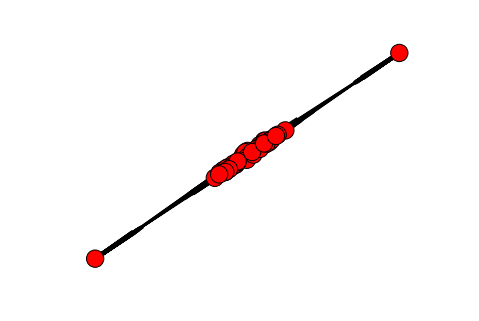

Name: gnp_random_graph(50,0.5)
Type: DiGraph
Number of nodes: 50
Number of edges: 1238
Average in degree:  24.7600
Average out degree:  24.7600


In [6]:
################################################################################
### Data graph plot
################################################################################
pos = nx.spring_layout(data.G)
nx.draw(data.G)
plt.show()
print nx.info(data.G)

In [7]:
################################################################################
### Hypotheses
################################################################################
H0 = data
H1 = JANUS(algorithm='uniform',isdirected=DIRECTED,isweighted=WEIGHTED,isglobal=GLOBAL,norm=NORM,mode=MODE,n=NODES,p=UNIFORM)
H2 = JANUS(algorithm='erdos-renyi',isdirected=DIRECTED,isweighted=WEIGHTED,isglobal=GLOBAL,norm=NORM,mode=MODE,minw=MINW,maxw=MAXW,n=NODES,p=0.01)
H3 = JANUS(algorithm='erdos-renyi',isdirected=DIRECTED,isweighted=WEIGHTED,isglobal=GLOBAL,norm=NORM,mode=MODE,minw=MINW,maxw=MAXW,n=NODES,p=1.0)
H4 = JANUS(algorithm='erdos-renyi',isdirected=DIRECTED,isweighted=WEIGHTED,isglobal=GLOBAL,norm=NORM,mode=MODE,minw=MINW,maxw=MAXW,n=NODES,p=UNIFORM)
H5 = JANUS(algorithm='erdos-renyi',isdirected=DIRECTED,isweighted=WEIGHTED,isglobal=GLOBAL,norm=NORM,mode=MODE,minw=MINW,maxw=MAXW,n=NODES,p=P)
H6 = JANUS(algorithm='barabassi',isdirected=DIRECTED,isweighted=WEIGHTED,isglobal=GLOBAL,norm=NORM,mode=MODE,minw=MINW,maxw=MAXW,n=NODES,m=EDGES)
H7 = JANUS(algorithm='geometric',isdirected=DIRECTED,isweighted=WEIGHTED,isglobal=GLOBAL,norm=NORM,mode=MODE,minw=MINW,maxw=MAXW,n=NODES,r=RADIUS)

In [8]:
################################################################################
### Generating Adjacency matrices
################################################################################
H1.createGraph()
H2.createGraph()
H3.createGraph()
H4.createGraph()
H5.createGraph()
H6.createGraph()
H7.createGraph()
H8 = H0.copyWithNoise(1.)
H9 = H0.copyWithNoise(5.)
H10 = H0.copyWithNoise(10.)
H11 = H0.copyWithNoise(100.)
H12 = H0.copyWithNoise(1000.)

In [9]:
################################################################################
### Evidences
################################################################################
hypotheses = {'data':H0, 'uniform-{0:.2f}'.format(UNIFORM):H1,'Erdos-Renyi-0.1':H2,'Erdos-Renyi-1.0':H3,'Erdos-Renyi-{0:.2f}'.format(UNIFORM):H4,'Erdos-Renyi-{}'.format(P):H5,'Barabassi-m{}'.format(EDGES):H6,'Geometric-{}'.format(RADIUS):H7,'Noise-1.0':H8,'Noise-5.0':H9,'Noise-10.0':H10,'Noise-100.0':H11,'Noise-1000.0':H12}
evidences = {}
vocab = getVocabulary(data.G)

### Modelling Linkage
model = CategoricalDistribution(use_prior=True, prior=1., specific_prior_vocab = vocab, modus='bayes', isdirected=DIRECTED)
model.prepare_data(data.G)
model.fit(data.G)

### Generating Evidences for each hypothesis and value of k 
for id,hg in hypotheses.items():
    evidences[id] = {}
    for k in WEIGHTING_FACTORS:
        prior = hg.elicit_prior(k)
        model.setSpecificPrior(prior)
        e = model.evidence()
        evidences[id][k] = e
        

/Library/Python/2.7/site-packages/ipykernel/__main__.py:143: RuntimeWarning: invalid value encountered in divide


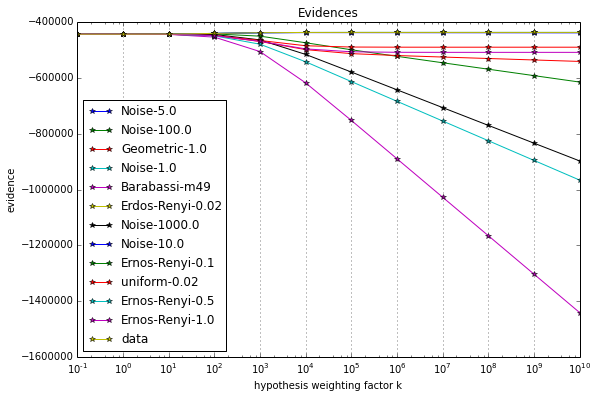

In [10]:
plotEvidences(evidences)

In [11]:
################################################################################
### Summary: Rank
################################################################################
rank = {}
for hname,evidencesobj in evidences.items():
    v = float(evidencesobj[Kprint])
    if not np.isnan(v):
        rank[hname] = v
    else:
        print hname

sortedr = sorted(rank.items(), key=operator.itemgetter(1),reverse=True)
print 'Data generated as {} with p={}'.format(ALGO,P)
print '===== RANK ====='
print '\n'.join(['{0:25s}{1:<.5f}'.format(str(e[0]),float(e[1])) for e in sortedr])

Erdos-Renyi-0.02
Ernos-Renyi-0.1
Data generated as erdos-renyi with p=0.5
===== RANK =====
Noise-1.0                -436824.57494
data                     -436824.57494
Noise-5.0                -436985.79935
Noise-10.0               -437622.27640
uniform-0.02             -489187.20147
Noise-100.0              -498939.80609
Ernos-Renyi-1.0          -506173.87731
Geometric-1.0            -512804.83489
Noise-1000.0             -578660.65298
Ernos-Renyi-0.5          -612825.89112
Barabassi-m49            -752059.01782
